Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.


# Diffusion Models for Implicit Image Segmentation Ensembles<br>
<br>
This tutorial illustrates how to use MONAI for 2D segmentation of images using DDPMs, as proposed in [1].<br>
The same structure can also be used for conditional image generation, or image-to-image translation, as proposed in [2,3].
<br>
<br>
[1] - Wolleb et al. "Diffusion Models for Implicit Image Segmentation Ensembles", https://arxiv.org/abs/2112.03145<br>
[2] - Waibel et al. "A Diffusion Model Predicts 3D Shapes from 2D Microscopy Images", https://arxiv.org/abs/2208.14125<br>
[3] - Durrer et al. "Diffusion Models for Contrast Harmonization of Magnetic Resonance Images", https://aps.arxiv.org/abs/2303.08189



## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import seaborn" || pip install -q seaborn


## Setup imports

In [ ]:
import os
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch import GradScaler, autocast
from tqdm import tqdm

from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler

torch.multiprocessing.set_sharing_strategy("file_system")
print_config()

## Setup data directory

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

## Set deterministic training for reproducibility

In [3]:
set_determinism(42)


## Preprocessing of the BRATS Dataset in 2D slices for training
We download the BRATS training dataset from the Decathlon dataset.


In [4]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"


train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
    ]
)

In [64]:
batch_size = 32

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)

print(f"Length of training data: {len(train_ds)}")  # this gives the number of patients in the training set
print(f'Train image shape {train_ds[0]["image"].shape}')
print(f'Train label shape {train_ds[0]["label"].shape}')


train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████| 388/388 [02:59<00:00,  2.16it/s]


Length of training data: 388
Train image shape torch.Size([1, 64, 64])
Train label shape torch.Size([1, 64, 64])


## Preprocessing of the BRATS Dataset in 2D slices for validation
We download the BRATS validation dataset from the Decathlon dataset. We define the dataloader to load 2D slices as well as the corresponding ground truth tumor segmentation for validation.

In [65]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(val_ds)}")
print(f'Validation Image shape {val_ds[0]["image"].shape}')
print(f'Validation Label shape {val_ds[0]["label"].shape}')

val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████| 96/96 [00:45<00:00,  2.12it/s]

Length of training data: 96
Validation Image shape torch.Size([1, 64, 64])
Validation Label shape torch.Size([1, 64, 64])



## Define network, scheduler, optimizer, and inferer

At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using the DDPM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms in the 3rd level (`num_head_channels=64`).<br>


In [ ]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=1,
    channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
)
model.to(device)

In [68]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)
inferer = DiffusionInferer(scheduler)

## Model training of the Diffusion Model<br>
We train our diffusion model for 4000 epochs.\
In every step, we concatenate the original MR image to the noisy segmentation mask, to predict a slightly denoised segmentation mask.\
This is described in Equation 7 of the paper https://arxiv.org/pdf/2112.03145.pdf.

Epoch 0 Validation loss 0.95528511206309
Epoch 50 Validation loss 0.012534369714558125
Epoch 100 Validation loss 0.006971345127870639
Epoch 150 Validation loss 0.007212877739220858
...
train diffusion completed, total time: 11462.321615695953.


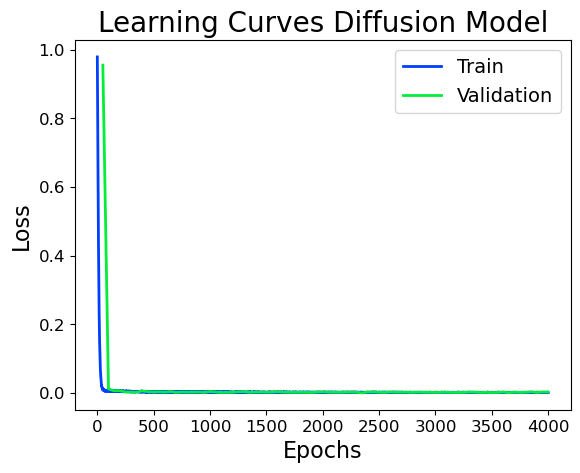

In [72]:
max_epochs = 4000
val_interval = 50
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler("cuda")
total_start = time.time()

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0

    for _step, data in enumerate(train_loader):
        images = data["image"].to(device)
        seg = data["label"].to(device)  # this is the ground truth segmentation
        optimizer.zero_grad(set_to_none=True)
        timesteps = torch.randint(0, 1000, (len(images),)).to(device)  # pick a random time step t

        with autocast("cuda", enabled=True):
            # Generate random noise
            noise = torch.randn_like(seg).to(device)
            noisy_seg = scheduler.add_noise(
                original_samples=seg, noise=noise, timesteps=timesteps
            )  # we only add noise to the segmentation mask
            combined = torch.cat(
                (images, noisy_seg),
                dim=1,
                # we concatenate the brain MR image with the noisy segmenatation mask
                # to condition the generation process
            )
            prediction = model(x=combined, timesteps=timesteps)
            # Get model prediction
            loss = F.mse_loss(prediction.float(), noise.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    epoch_loss_list.append(epoch_loss / (_step + 1))
    if (epoch) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for _step, data_val in enumerate(val_loader):
            images = data_val["image"].to(device)
            seg = data_val["label"].to(device)  # this is the ground truth segmentation
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)
            with torch.no_grad():
                with autocast("cuda", enabled=True):
                    noise = torch.randn_like(seg).to(device)
                    noisy_seg = scheduler.add_noise(original_samples=seg, noise=noise, timesteps=timesteps)
                    combined = torch.cat((images, noisy_seg), dim=1)
                    prediction = model(x=combined, timesteps=timesteps)
                    val_loss = F.mse_loss(prediction.float(), noise.float())
            val_epoch_loss += val_loss.item()
        print("Epoch", epoch, "Validation loss", val_epoch_loss / (_step + 1))
        val_epoch_loss_list.append(val_epoch_loss / (_step + 1))

torch.save(model.state_dict(), "./segmodel.pt")
total_time = time.time() - total_start
print(f"train diffusion completed, total time: {total_time}.")

plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

## Sampling of a new segmentation mask for an input image of the validation set<br>

Starting from random noise, we want to generate a segmentation mask for a brain MR image of our validation set.\
Due to the stochastic generation process, we can sample an ensemble of n different segmentation masks per MR image.\
First, we pick an image of our validation set, and check the ground truth segmentation mask.

In [ ]:
idx = 0
data = val_ds[idx]
inputimg = data["image"][0, ...]  # Pick an input slice of the validation set to be segmented
inputlabel = data["label"][0, ...]  # Check out the ground truth label mask. If it is empty, pick another input slice.


plt.figure("input" + str(inputlabel))
plt.imshow(inputimg, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

plt.figure("input" + str(inputlabel))
plt.imshow(inputlabel, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()


model.eval()

Then we set the number of samples in the ensemble n. \
Starting from the input image (which ist the brain MR image), we follow Algorithm 1 of the paper "Diffusion Models for Implicit Image Segmentation Ensembles" (https://arxiv.org/pdf/2112.03145.pdf) n times.\
This gives us an ensemble of n different predicted segmentation masks.

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.45it/s]


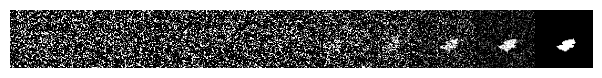

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.95it/s]


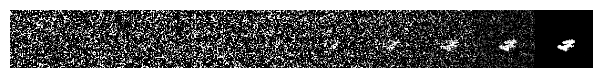

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.05it/s]


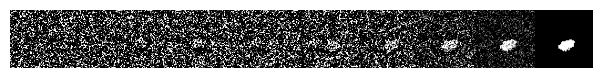

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.93it/s]


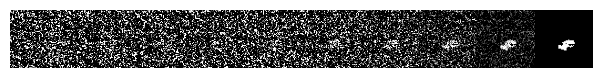

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.06it/s]


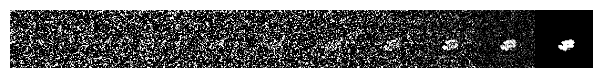

In [122]:
n = 5
input_img = inputimg[None, None, ...].to(device)
ensemble = []
for _ in range(5):
    noise = torch.randn_like(input_img).to(device)
    current_img = noise  # for the segmentation mask, we start from random noise.
    combined = torch.cat(
        (input_img, noise), dim=1
    )  # We concatenate the input brain MR image to add anatomical information.

    scheduler.set_timesteps(num_inference_steps=1000)
    progress_bar = tqdm(scheduler.timesteps)
    chain = torch.zeros(current_img.shape)
    for t in progress_bar:  # go through the noising process
        with autocast("cuda", enabled=False):
            with torch.no_grad():
                model_output = model(combined, timesteps=torch.Tensor((t,)).to(current_img.device))
                current_img, _ = scheduler.step(
                    model_output, t, current_img
                )  # this is the prediction x_t at the time step t
                if t % 100 == 0:
                    chain = torch.cat((chain, current_img.cpu()), dim=-1)
                combined = torch.cat(
                    (input_img, current_img),
                    dim=1,
                    # in every step during the denoising process
                    # the brain MR image is concatenated to add anatomical information
                )

    plt.style.use("default")
    plt.imshow(chain[0, 0, ..., 64:].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    ensemble.append(current_img)  # this is the output of the diffusion model after T=1000 denoising steps


## Segmentation prediction
The predicted segmentation mask is obtained from the output of the diffusion model by thresholding.\
We compute the Dice score for all predicted segmentations of the ensemble, as well as the pixel-wise mean and the variance map over the ensemble.\
As shown in the paper "Diffusion Models for Implicit Image Segmentation Ensembles" (https://arxiv.org/abs/2112.03145), we see that taking the mean over n=5 samples improves the segmentation performance.\
The variance maps highlights pixels where the model is unsure about it's own prediction.



In [123]:
def dice_coeff(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient between two arrays.
    """
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2.0 * intersection.sum() / im_sum

Dice score of sample0 0.8455882352941176
Dice score of sample1 0.860655737704918
Dice score of sample2 0.8475836431226765
Dice score of sample3 0.8820960698689956
Dice score of sample4 0.8627450980392157
Dice score on the mean map 0.889763779527559


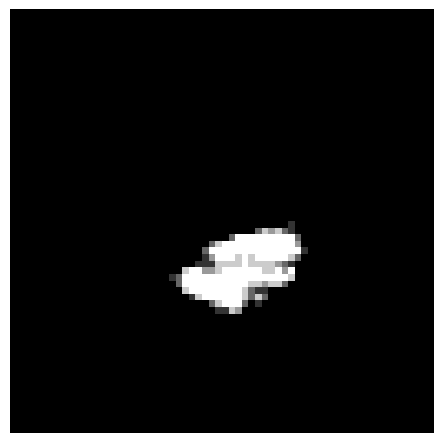

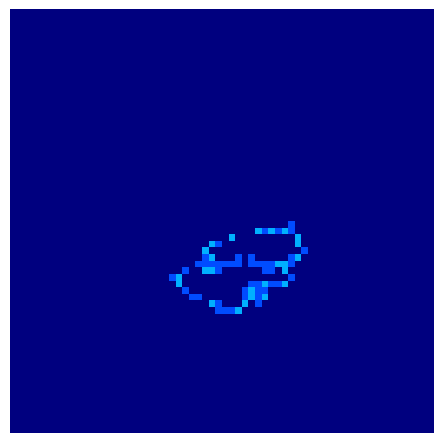

In [128]:
for i in range(len(ensemble)):
    prediction = torch.where(ensemble[i] > 0.5, 1, 0).float()  # a binary mask is obtained via thresholding
    score = dice_coeff(
        prediction[0, 0].cpu(), inputlabel.cpu()
    )  # we compute the dice scores for all samples separately
    print("Dice score of sample" + str(i), score)


E = torch.where(torch.cat(ensemble) > 0.5, 1, 0).float()
var = torch.var(E, dim=0)  # pixel-wise variance map over the ensemble
mean = torch.mean(E, dim=0)  # pixel-wise mean map over the ensemble
mean_prediction = torch.where(mean > 0.5, 1, 0).float()

score = dice_coeff(mean_prediction[0, ...].cpu(), inputlabel.cpu())  # Here we predict the Dice score for the mean map
print("Dice score on the mean map", score)

plt.style.use("default")
plt.imshow(mean[0, ...].cpu(), vmin=0, vmax=1, cmap="gray")  # We plot the mean map
plt.tight_layout()
plt.axis("off")
plt.show()
plt.style.use("default")
plt.imshow(var[0, ...].cpu(), vmin=0, vmax=1, cmap="jet")  # We plot the variance map
plt.tight_layout()
plt.axis("off")
plt.show()